# Phase 2: Advanced Deep Learning Model Suite

In this notebook, we benchmark three state-of-the-art neural network architectures for tabular data to find the best balance of accuracy and efficiency.

### 🏆 The Contenders:
1. **DeepFM (Deep Factorization Machine)**: Combines explicit high-order feature interactions (Neural Network) with low-order interactions (Factorization Machine). Great for capturing user behavior patterns.
2. **TabM (Tabular Mini-Ensemble)**: A unified neural network that acts like an efficient ensemble. We use `K=4` ensemble heads for speed.
3. **FT-Transformer (feature Tokenizer + Transformer)**: Adapts the "Attention" mechanism from ChatGPT/BERT to tabular features. Often provides SOTA accuracy but is computationally heavier.

---

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import json

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using Device: {DEVICE}")


# Config
DATA_PATH = "../data/raw/online_shoppers_intention.csv"
MODELS_PATH = "../backend/models"
REPORTS_PATH = "../reports/metrics"
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

🔥 Using Device: cpu


## 1. Data Pipeline (Categorical Embeddings)
To give DeepFM and Transformers a fair chance, we must treat Categorical variables (Month, VisitorType, etc.) as **Embeddings**, not just numbers.

In [13]:
def load_and_preprocess():
    df = pd.read_csv(DATA_PATH)
    
    # Target
    y = df['Revenue'].astype(int).values
    
    # Feature Engineering / Definition
    cat_cols = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'SpecialDay']
    # Ensure SpecialDay is treated as category or float? Let's treat as simple num for now unless cardinality is low.
    # Actually 'SpecialDay' is float (0.0, 0.2...) let's keep it num. 
    cat_cols = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
    
    num_cols = [c for c in df.columns if c not in cat_cols and c != 'Revenue']
    
    # 1. Process Categorical (Label Encoding for Embeddings)
    X_cat = np.zeros((len(df), len(cat_cols)), dtype=np.int64)
    cat_dims = [] # To store cardinality of each feature
    
    for i, col in enumerate(cat_cols):
        le = LabelEncoder()
        X_cat[:, i] = le.fit_transform(df[col].astype(str))
        cat_dims.append(len(le.classes_))
        
    # 2. Process Numerical (Standard Scaling)
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_cols]).astype(np.float32)
    
    # Split
    X_cat_train, X_cat_temp, X_num_train, X_num_temp, y_train, y_temp = train_test_split(
        X_cat, X_num, y, test_size=0.2, random_state=42, stratify=y
    )
    X_cat_val, X_cat_test, X_num_val, X_num_test, y_val, y_test = train_test_split(
        X_cat_temp, X_num_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    data = {
        'train': (torch.tensor(X_cat_train), torch.tensor(X_num_train), torch.tensor(y_train, dtype=torch.float32)),
        'val': (torch.tensor(X_cat_val), torch.tensor(X_num_val), torch.tensor(y_val, dtype=torch.float32)),
        'test': (torch.tensor(X_cat_test), torch.tensor(X_num_test), torch.tensor(y_test, dtype=torch.float32)),
        'cat_dims': cat_dims,
        'num_dim': X_num.shape[1],
        'cat_cols': cat_cols,
        'num_cols': num_cols
    }
    
    print(f"✅ Data Loaded. Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")
    print(f"   Categorical Features: {len(cat_cols)} (Dims: {cat_dims})")
    print(f"   Numerical Features: {len(num_cols)}")
    
    return data

full_data = load_and_preprocess()

✅ Data Loaded. Train: 9864, Val: 1233, Test: 1233
   Categorical Features: 7 (Dims: [10, 3, 2, 8, 13, 9, 20])
   Numerical Features: 10


## 2. Model Architectures

In [14]:
class FeatureEmbedding(nn.Module):
    """Helper to embed categorical features"""
    def __init__(self, cat_dims, embed_dim):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=d, embedding_dim=embed_dim) for d in cat_dims
        ])
        
    def forward(self, x_cat):
        # x_cat: [Batch, n_cat]
        # Output: [Batch, n_cat, embed_dim]
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        return torch.stack(embedded, dim=1)

# -----------------------------------------------------
# 1. DeepFM
# -----------------------------------------------------
class DeepFM(nn.Module):
    def __init__(self, cat_dims, num_dim, embed_dim=16, hidden_dims=[128, 64]):
        super().__init__()
        self.embedding = FeatureEmbedding(cat_dims, embed_dim)
        
        # Linear Part (FM w0 + w1*x)
        # For simplicity in DeepFM, the "Linear" part is often just a dense layer over raw features 
        # or embeddings. We'll project continuous to embed_dim too for the interaction part.
        self.num_proj = nn.Linear(1, embed_dim)
        
        total_input_dim = (len(cat_dims) + num_dim) * embed_dim
        
        # Deep Part (MLP)
        layers = []
        curr_dim = total_input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(curr_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            curr_dim = h
        layers.append(nn.Linear(curr_dim, 1))
        self.mlp = nn.Sequential(*layers)
        
        # FM Part (pair-wise dot products)
        # Output is scaler sum of all dot products
        
    def forward(self, x_cat, x_num):
        # Embed Categorical: [B, n_cat, E]
        emb_cat = self.embedding(x_cat)
        
        # Embed Numerical: [B, n_num, 1] -> [B, n_num, E]
        # Simple approach: Treat each float as a weight for a shared embedding vector or project it
        # Here we just project independent scalars to vectors
        b, n = x_num.shape
        x_num_unsqueezed = x_num.unsqueeze(-1) # [B, n_num, 1]
        emb_num = self.num_proj(x_num_unsqueezed) # [B, n_num, E]
        
        # Concatenate all fields for FM interactions: [B, n_features, E]
        all_emb = torch.cat([emb_cat, emb_num], dim=1)
        
        # --- FM Component ---
        # sum_square = (sum(vi*xi))^2
        sum_of_vectors = torch.sum(all_emb, dim=1) # [B, E]
        sum_square = sum_of_vectors * sum_of_vectors
        
        # square_sum = sum((vi*xi)^2)
        square_of_vectors = all_emb * all_emb
        square_sum = torch.sum(square_of_vectors, dim=1) # [B, E]
        
        # bit-wise subtract, then sum over embedding dim
        fm_out = 0.5 * torch.sum(sum_square - square_sum, dim=1, keepdim=True) # [B, 1]
        
        # --- Deep Component ---
        dnn_in = all_emb.view(b, -1) # Flatten
        dnn_out = self.mlp(dnn_in)
        
        # Combine
        return dnn_out + fm_out

# -----------------------------------------------------
# 2. TabM (Improved)
# -----------------------------------------------------
class TabM_K4(nn.Module):
    def __init__(self, cat_dims, num_dim, hidden_dim=128, n_ensemble=4):
        super().__init__()
        # For TabM, we usually concat one-hot encoded cats and raw nums
        # But to be fair to comparison, we can flatten embeddings
        self.embedding = FeatureEmbedding(cat_dims, embed_dim=4) # Small embed for TabM
        input_dim = (len(cat_dims) * 4) + num_dim
        
        self.bn_in = nn.BatchNorm1d(input_dim)
        
        # Original TabM Logic: Ensemble of efficient blocks
        self.ensemble_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.GELU(),
            ) for _ in range(n_ensemble)
        ])
        self.heads = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(n_ensemble)
        ])
        
    def forward(self, x_cat, x_num):
        emb_cat = self.embedding(x_cat).flatten(1)
        x_in = torch.cat([emb_cat, x_num], dim=1)
        x_in = self.bn_in(x_in)
        
        outputs = [head(block(x_in)) for block, head in zip(self.ensemble_blocks, self.heads)]
        stacked = torch.stack(outputs, dim=0)
        return stacked.mean(dim=0)

# -----------------------------------------------------
# 3. FT-Transformer
# -----------------------------------------------------
class FTTransformer(nn.Module):
    def __init__(self, cat_dims, num_dim, embed_dim=32, depth=3, heads=4):
        super().__init__()
        self.embedding = FeatureEmbedding(cat_dims, embed_dim)
        self.num_proj = nn.Linear(1, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=heads, 
            dim_feedforward=embed_dim*2, 
            dropout=0.1,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.head = nn.Linear(embed_dim, 1)
        
    def forward(self, x_cat, x_num):
        b = x_cat.shape[0]
        emb_cat = self.embedding(x_cat)
        emb_num = self.num_proj(x_num.unsqueeze(-1))
        
        # [B, N_features, E]
        x = torch.cat([emb_cat, emb_num], dim=1)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Transformer Pass
        x = self.transformer(x)
        
        # Predict from CLS token
        cls_out = x[:, 0, :]
        return self.head(cls_out)

print("✅ Model Architectures Defined.")

✅ Model Architectures Defined.


## 3. Training Loop

🚀 Starting Tournament (Balanced Implementation)...

🚀 Training DeepFM (Balance Weight: 5.46)...
  Epoch 5: Loss = 90.9084, Val AUC = 0.5137
  Epoch 10: Loss = 16.7088, Val AUC = 0.7073
  Epoch 15: Loss = 6.3319, Val AUC = 0.7691
  Epoch 20: Loss = 4.5056, Val AUC = 0.8080
  Epoch 25: Loss = 4.1451, Val AUC = 0.8247
  Epoch 30: Loss = 4.0365, Val AUC = 0.8281
  ↺ Reloaded best model weights from deepfm.pt
🏁 Finished DeepFM. Best Val AUC: 0.8304. Time: 188.9s


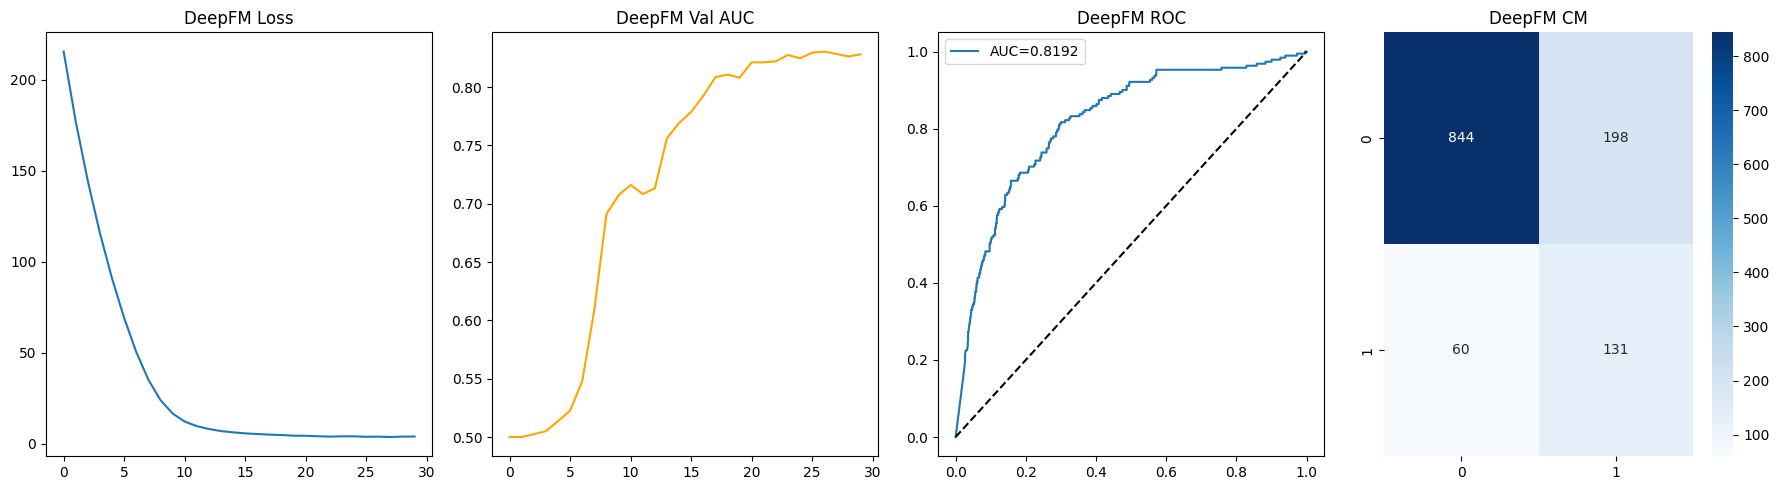


🚀 Training TabM_K4 (Balance Weight: 5.46)...
  Epoch 5: Loss = 0.5716, Val AUC = 0.9188
  Epoch 10: Loss = 0.5030, Val AUC = 0.9210
  Epoch 15: Loss = 0.4612, Val AUC = 0.9214
  Epoch 20: Loss = 0.4235, Val AUC = 0.9199
  Epoch 25: Loss = 0.4090, Val AUC = 0.9196
  Epoch 30: Loss = 0.4018, Val AUC = 0.9178
  ↺ Reloaded best model weights from tabm_k4.pt
🏁 Finished TabM_K4. Best Val AUC: 0.9221. Time: 276.3s


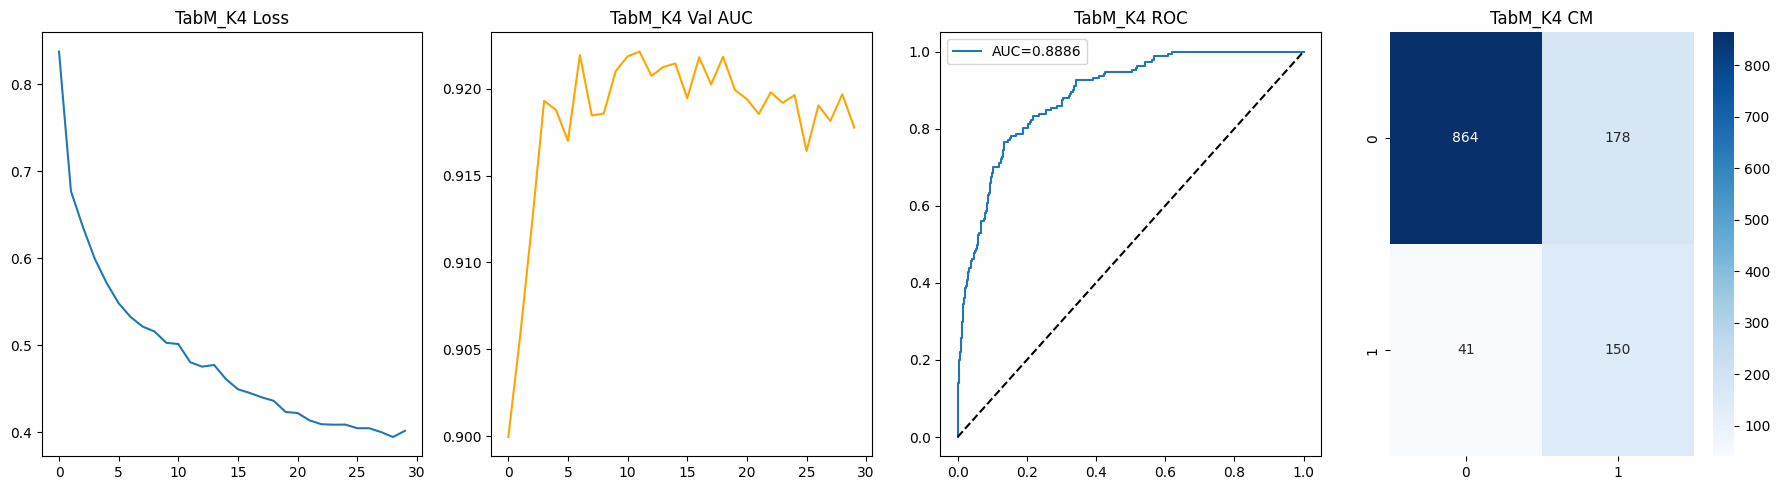


🚀 Training FT-Transformer (Balance Weight: 5.46)...
  Epoch 5: Loss = 0.9554, Val AUC = 0.7698
  Epoch 10: Loss = 0.9406, Val AUC = 0.7763
  Epoch 15: Loss = 0.9144, Val AUC = 0.7769
  Epoch 20: Loss = 0.9112, Val AUC = 0.7766
  ↺ Reloaded best model weights from ft-transformer.pt
🏁 Finished FT-Transformer. Best Val AUC: 0.7769. Time: 405.8s


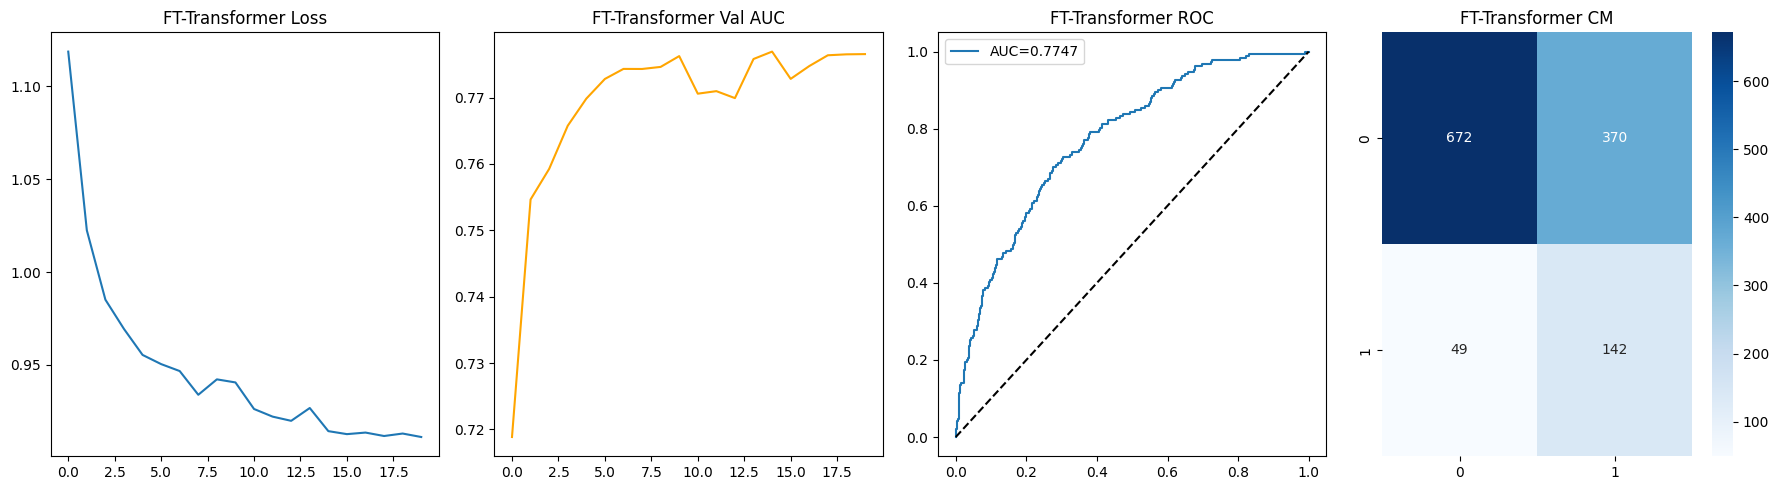

In [15]:
def train_model(model, name, epochs=30, batch_size=256):
    start_time = time.time()
    model = model.to(DEVICE)
    
    # ⚖️ Handle Imbalance (New)
    X_c_tr, X_n_tr, y_tr = full_data['train']
    X_c_val, X_n_val, y_val = full_data['val']
    
    pos_counts = (y_tr == 1).sum()
    neg_counts = (y_tr == 0).sum()
    pos_weight = torch.tensor([neg_counts / pos_counts]).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # Balanced Loss
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    dataset = TensorDataset(X_c_tr, X_n_tr, y_tr)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    best_auc = 0
    history = {'train_loss': [], 'val_auc': []}
    
    print(f"\n🚀 Training {name} (Balance Weight: {pos_weight.item():.2f})...")
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for xc, xn, y in loader:
            xc, xn, y = xc.to(DEVICE), xn.to(DEVICE), y.to(DEVICE)
            
            optimizer.zero_grad()
            out = model(xc, xn).squeeze()
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
        scheduler.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(X_c_val.to(DEVICE), X_n_val.to(DEVICE)).squeeze()
            val_probs = torch.sigmoid(val_out).cpu().numpy()
            auc = roc_auc_score(y_val.numpy(), val_probs)
            
        history['train_loss'].append(avg_loss/len(loader))
        history['val_auc'].append(auc)
            
        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), f"{MODELS_PATH}/{name.lower()}.pt")
            
        if (epoch+1) % 5 == 0:
            print(f"  Epoch {epoch+1}: Loss = {avg_loss/len(loader):.4f}, Val AUC = {auc:.4f}")
            
    
    # Reload best model weights for final evaluation
    if best_auc > 0:
        model.load_state_dict(torch.load(f"{MODELS_PATH}/{name.lower()}.pt"))
        print(f"  ↺ Reloaded best model weights from {name.lower()}.pt")
    
    training_time = time.time() - start_time
    print(f"🏁 Finished {name}. Best Val AUC: {best_auc:.4f}. Time: {training_time:.1f}s")
    
    return best_auc, training_time, history

def evaluate_and_plot(model, name, history):
    # 1. Prediction
    X_c_ts, X_n_ts, y_ts = full_data['test']
    model.eval()
    with torch.no_grad():
        out = model(X_c_ts.to(DEVICE), X_n_ts.to(DEVICE)).squeeze()
        probs = torch.sigmoid(out).cpu().numpy()
        preds = (probs > 0.5).astype(int)
    
    y_true = y_ts.numpy()
    
    # 2. Metrics
    res = {
        'AUC': roc_auc_score(y_true, probs),
        'F1': f1_score(y_true, preds),
        'Precision': precision_score(y_true, preds),
        'Recall': recall_score(y_true, preds)
    }
    
    # 3. Visualization
    plt.figure(figsize=(18, 5))
    
    # Training Loss/AUC
    plt.subplot(1, 4, 1)
    plt.plot(history['train_loss'])
    plt.title(f'{name} Loss')
    
    plt.subplot(1, 4, 2)
    plt.plot(history['val_auc'], color='orange')
    plt.title(f'{name} Val AUC')
    
    # ROC Curve
    plt.subplot(1, 4, 3)
    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.plot(fpr, tpr, label=f'AUC={res["AUC"]:.4f}')
    plt.plot([0,1],[0,1], 'k--')
    plt.title(f'{name} ROC')
    plt.legend()
    
    # CM
    plt.subplot(1, 4, 4)
    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} CM')
    
    plt.tight_layout()
    plt.show()
    
    return res

cat_dims = full_data['cat_dims']
num_dim = full_data['num_dim']

results = {}

print("🚀 Starting Tournament (Balanced Implementation)...")

# 1. Train DeepFM
model_dfm = DeepFM(cat_dims, num_dim)
auc_dfm, time_dfm, hist_dfm = train_model(model_dfm, "DeepFM")
results['DeepFM'] = evaluate_and_plot(model_dfm, "DeepFM", hist_dfm)
results['DeepFM']['Time'] = time_dfm

# 2. Train TabM (K=4)
model_tabm = TabM_K4(cat_dims, num_dim, n_ensemble=4)
auc_tabm, time_tabm, hist_tabm = train_model(model_tabm, "TabM_K4")
results['TabM_K4'] = evaluate_and_plot(model_tabm, "TabM_K4", hist_tabm)
results['TabM_K4']['Time'] = time_tabm

# 3. Train FT-Transformer
model_ft = FTTransformer(cat_dims, num_dim)
auc_ft, time_ft, hist_ft = train_model(model_ft, "FT-Transformer", epochs=20)
results['FT-Transformer'] = evaluate_and_plot(model_ft, "FT-Transformer", hist_ft)
results['FT-Transformer']['Time'] = time_ft

## 4. Final Comparison

In [16]:
print("\n" + "="*90)
print(f"{'Model':<20} {'AUC':<10} {'F1':<10} {'Precision':<10} {'Recall':<10} {'Time':<10}")
print("-"*90)
for name, res in results.items():
    print(f"{name:<20} {res['AUC']:.4f}     {res['F1']:.4f}     {res['Precision']:.4f}     {res['Recall']:.4f}     {res['Time']:.1f}s")
print("="*90)

# Save Benchmark
with open(f"{REPORTS_PATH}/deep_learning_benchmark.json", "w") as f:
    json.dump(results, f, indent=4)


Model                AUC        F1         Precision  Recall     Time      
------------------------------------------------------------------------------------------
DeepFM               0.8192     0.5038     0.3982     0.6859     188.9s
TabM_K4              0.8886     0.5780     0.4573     0.7853     276.3s
FT-Transformer       0.7747     0.4040     0.2773     0.7435     405.8s
